In [2]:
## Boring Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
logging.getLogger().setLevel(logging.DEBUG)

import pandas as pd
import json
import os
import trappy
from trace import Trace
from executor import Executor

from bart.common.Utils import select_window, area_under_curve

In [4]:
events = [
            "sched_overutilized",
            "sched_migrate_task",
            "sched_switch",
            "cpu_idle",
            "cpu_frequency",
            "irq*"
        ]

## Running Workload

In [9]:

tests_conf = {
    "exclude_modules"  : [ "hwmon" ],
    "tools"    : [ "rt-app" ],
    "ftrace" : {
        "events" : events
    },
    "wloads" : {
        "two_eightypercent" : {
            "type" : "rt-app",
            "conf" : {
                "class" : "periodic",
                "params" : {
                    "duty_cycle_pct": 80,
                    "duration_s": 1,
                    "period_ms": 10,
                },
                "tasks" : 2,
                "prefix" : "many",
            },
        },
    },
    "iterations": 1,
    "confs" : [
        {
            "tag" : "",
            "flags" : "ftrace",
            "sched_features" : "ENERGY_AWARE",
            "cpufreq" : {
                "governor" : "ondemand"
            },
        }
    ]
}

executor = Executor(tests_conf=tests_conf)

06:05:56  INFO    :         Target - Loading custom (inline) test configuration
06:05:56  INFO    :         Target - Using base path: /vagrant
06:05:56  INFO    :         Target - Loading default (file) target configuration
06:05:56  INFO    :         Target - Loading target configuration [/vagrant/target.config]...
06:05:56  INFO    :         Target - Loading custom (inline) test configuration
06:05:56  INFO    :       Platform - Loading board:
06:05:56  INFO    :       Platform -    /vagrant/libs/utils/platforms/hikey.json
06:05:56  INFO    :         Target - Devlib modules to load: [u'bl', u'cpuidle', u'cpufreq']
06:05:56  INFO    :         Target - Connecting linux target:
06:05:56  INFO    :         Target -   username : linaro
06:05:56  INFO    :         Target -       host : 192.168.2.2
06:05:56  INFO    :         Target -   password : linaro
06:05:56  INFO    :         Target - Connection settings:
06:05:56  INFO    :         Target -    {'username': u'linaro', 'host': u'192.16

In [11]:
executor.run()

06:06:38  INFO    : 
06:06:38  INFO    : ################################################################################
06:06:38  INFO    :       Executor - Experiments execution
06:06:38  INFO    : ################################################################################
06:06:38  INFO    : 
06:06:38  INFO    : ================================================================================
06:06:38  INFO    :   TargetConfig - configuring target for [] experiments
06:06:40  INFO    :  SchedFeatures - Set scheduler feature: ENERGY_AWARE
06:06:40  INFO    :        CPUFreq - Configuring all CPUs to use [ondemand] governor
06:06:41  INFO    :          WlGen - Setup new workload two_eightypercent
06:06:41  INFO    :          RTApp - Workload duration defined by longest task
06:06:41  INFO    :          RTApp - Default policy: SCHED_OTHER
06:06:41  INFO    :          RTApp - ------------------------
06:06:41  INFO    :          RTApp - task [many0], sched: using default policy
06:0

In [15]:
events =  ["sched_overutilized", "cpu_frequency", "cpu_idle", "sched_switch"]
experiment = executor.experiments[0]
trace_path = experiment.out_dir
trace = Trace(executor.te.platform, trace_path, events)

06:08:36  INFO    : Parsing FTrace format...
06:08:40  INFO    : Platform clusters verified to be Frequency coherent
06:08:40  INFO    : Collected events spans a 6.281 [s] time interval
06:08:40  INFO    : Set plots time range to (0.000000, 6.280773)[s]
06:08:40  INFO    : Registering trace analysis modules:
06:08:40  INFO    :    tasks
06:08:40  INFO    :    eas
06:08:40  INFO    :    latency
06:08:40  INFO    :    frequency
06:08:40  INFO    :    functions
06:08:40  INFO    :    idle
06:08:40  INFO    :    status
06:08:40  INFO    :    cpus


In [16]:
energy_model = executor.te.nrg_model

## Alternative: Use trace from a previous automated test run

In [5]:
# TODO: this doesn't really work...
if True: # Un-False if you want to use this
    trace_path = "../../results_latest/rtapp::{}/1/trace.dat".format("two-eightypercent")

    platform_json_path = os.path.join(os.path.dirname(trace_path), "../platform.json")

    with open(platform_json_path) as f:
        platform = json.load(f)
    
    trace = Trace(platform, trace_path, events)

    from platforms.juno_energy import juno_energy
    from platforms.hikey_energy import hikey_energy

    energy_model = hikey_energy

06:04:12  INFO    : Parsing FTrace format...
06:04:14  INFO    : Platform clusters verified to be Frequency coherent
06:04:14  INFO    : Collected events spans a 7.316 [s] time interval
06:04:14  INFO    : Set plots time range to (0.000000, 7.316461)[s]
06:04:14  INFO    : Registering trace analysis modules:
06:04:14  INFO    :    tasks
06:04:14  INFO    :    eas
06:04:14  INFO    :    latency
06:04:14  INFO    :    frequency
06:04:14  INFO    :    functions
06:04:14  INFO    :    idle
06:04:14  INFO    :    status
06:04:14  INFO    :    cpus


## Plot Schedule

In [17]:
import trappy

print "tracing " + os.path.realpath(trace_path)
trappy.plotter.plot_trace(trace.ftrace)

tracing /vagrant/results/20161027_180613/rtapp::two_eightypercent/1


## Figure out period of workload execution

In [18]:
from bart.sched.SchedMultiAssert import SchedMultiAssert

In [19]:
tasks = experiment.wload.tasks.keys()
multi_assert = SchedMultiAssert(experiment.out_dir,
                                executor.te.topology,
                                tasks)
start = min(e['starttime'] for e in multi_assert.getStartTime().values())
end = min(e['endtime'] for e in multi_assert.getEndTime().values())
window = (start, end)
window

(1.8907859999999346, 3.1178270000000339)

## View energy estimation
`estimate_from_trace` uses the energy model to produce a trace of estimated power of each system component.
Each column is headed by a tuple with the CPUs in the component (CPU or cluster) represented. The "power" column contains the sum of the other columns.

In [20]:
power_df = energy_model.estimate_from_trace(trace)

06:08:50  INFO    :    EnergyModel - Estimating energy from trace - 55206 events...
06:08:58  INFO    :    EnergyModel - Done.


In [21]:
power_df = select_window(power_df, window)

Now plot the energy of each component. The `cumsum` along axis 1 (the horizontal axis) means that the plots for each component are stacked. 

Working out which line is which is left as an exercise to the reader. Also we should fill under the lines with 100% opacity but I can't get the JS library to do that for me.

In [22]:
import numpy as np

In [23]:
df = power_df.drop("power", 1).apply(np.cumsum, axis=1)
print df.columns
from trappy.plotter.ILinePlotGen import ILinePlotGen
gen = ILinePlotGen(2, per_line=1, title="power", 
                   max_datapoints={}, step_plot=True, fill=False, scatter=None, point_size=1000)
gen.add_plot(1, df)
gen.finish()

Index([(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (0, 1, 2, 3),
       (4, 5, 6, 7)],
      dtype='object')


""
""
""
""


## Find which resources over-used energy

Sum the energy used by each component over the period of workload execution.

In [24]:
df = pd.DataFrame(power_df)
columns = list(df.columns)
columns.remove("power")
estimated = {}
for column in columns:
    estimated[column] = area_under_curve(df[column]) / (window[1] - window[0])

print("Average estimated system power: %s" % sum(estimated.values()))
estimated

Average estimated system power: 885.241101969


{(0,): 272.87500865904474,
 (0, 1, 2, 3): 82.92822652216897,
 (1,): 0.1907968032805088,
 (2,): 0.0,
 (3,): 0.11557274770692914,
 (4,): 79.960620713121585,
 (4, 5, 6, 7): 63.897664788753858,
 (5,): 35.062355291858161,
 (6,): 0.11251661518546757,
 (7,): 350.09833982752542}

Get expected (ideal) energy usage

In [25]:
def task_capacity(task):
    # Must be a single-phase task
    [phase] = experiment.wload.params["profile"][task]["phases"]
    return (phase.duty_cycle_pct * energy_model.capacity_scale / 100.)

capacities = {t: task_capacity(t) for t in tasks}
_, utils = energy_model._find_optimal_placements(capacities)
util = utils[6]

06:09:15  INFO    :    EnergyModel - Searching 64 configurations for optimal task placement...
06:09:15  INFO    :    EnergyModel - Done


In [26]:
expected = energy_model.estimate_from_cpu_util(util, combine=True)
print("Average ideal system power: %s" % expected["power"])
del expected["power"]
expected

Average ideal system power: 1189.0


{(0,): 539.0,
 (0, 1, 2, 3): 111.0,
 (1,): 539.0,
 (2,): 0.0,
 (3,): 0.0,
 (4,): 0.0,
 (4, 5, 6, 7): 0.0,
 (5,): 0.0,
 (6,): 0.0,
 (7,): 0.0}

Show how much extra energy each component seemed to use

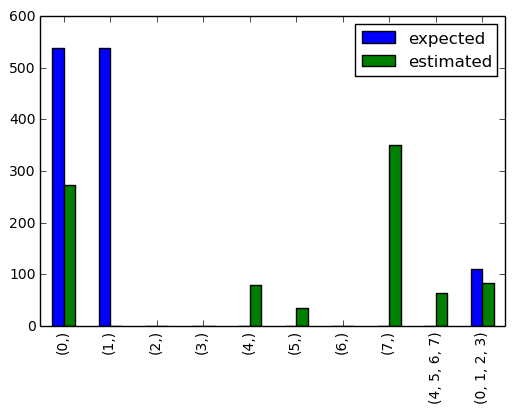

In [27]:
df_exp = pd.DataFrame(expected.values(), index=expected.keys())
df_est = pd.DataFrame(estimated.values(), index=estimated.keys())
df = pd.concat([df_exp, df_est], axis=1, join_axes=[df_exp.index])
df.columns = ["expected", "estimated"]
df.plot(kind="bar")

In [ ]:
trace.analysis.frequency.plotClusterFrequencies()

In [ ]:
trace.analysis.idle.plotClusterIdleStateResidency()
trace.analysis.idle.plotCPUIdleStateResidency()